In [29]:
import numpy as np
try:
    import sionna
except ImportError as e:
    import os
    os.system("py -m pip install sionna")
    import sionna
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.linalg import hadamard
import random

In [30]:
tx_params = {
    "nUsers" : 3,
    "powerAllocation_dB" : 0,
    "nMessage" : 6,
    "nCodeCDMA" : 128,
    "codes" : [],
    "nGold" : 1024
}

In [31]:
binary_source = sionna.utils.BinarySource()
channel = sionna.channel.AWGN()

ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber_OnlyCode = np.zeros(len(ebn0))
ber_ChannelNoise = np.zeros(len(ebn0))
ber_ZeroForcing = np.zeros(len(ebn0))
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    ber_OnlyCode_i = np.zeros(nb_seq)
    ber_ChannelNoise_i = np.zeros(nb_seq)
    ber_ZeroForcing_i = np.zeros(nb_seq)
    var_noise = 1/(10**(0.1*ebn0[i]))

    for j in range(nb_seq):

        BinarySource = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()

        data = BinarySource
        data_channel = utils.CDMA_encode(data, tx_params)

        signalOtherCells = np.zeros(data_channel.shape[0])
        for k in range(data_channel.shape[0]):
            signalOtherCells[k] = random.randint(0, 1)
        signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

        h = utils.Rayleigh_canal(alpha, len(data_channel))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape))
        channel = data_channel*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        zero_forcing = channel/h

        decoded_OnlyCode = utils.CDMA_decode(data_channel, tx_params)
        decoded_ChannelNoise = utils.CDMA_decode(channel, tx_params)
        decoded_ZeroForcing = utils.CDMA_decode(zero_forcing, tx_params)

        decoded_tf_OnlyCode = tf.convert_to_tensor(decoded_OnlyCode)
        decoded_tf_ChannelNoise = tf.convert_to_tensor(decoded_ChannelNoise)
        decoded_tf_ZeroForcing = tf.convert_to_tensor(decoded_ZeroForcing)

        BinarySource = tf.cast(tf.less(0.0, BinarySource), tf.float32)
        decoded_tf_OnlyCode = tf.cast(tf.less(0.0, decoded_tf_OnlyCode), tf.float32)
        decoded_tf_ChannelNoise = tf.cast(tf.less(0.0, decoded_tf_ChannelNoise), tf.float32)
        decoded_tf_ZeroForcing = tf.cast(tf.less(0.0, decoded_tf_ZeroForcing), tf.float32)

        ber_OnlyCode_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_OnlyCode)
        ber_ChannelNoise_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_ChannelNoise)
        ber_ZeroForcing_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_ZeroForcing)

        ber_OnlyCode_i[j] = ber_OnlyCode_j.numpy()
        ber_ChannelNoise_i[j] = ber_ChannelNoise_j.numpy()
        ber_ZeroForcing_i[j] = ber_ZeroForcing_j.numpy()
        
    ber_OnlyCode[i] = np.mean(ber_OnlyCode_i)
    ber_ChannelNoise[i] = np.mean(ber_ChannelNoise_i)
    ber_ZeroForcing[i] = np.mean(ber_ZeroForcing_i)

    print("Eb/N0 = " + str(ebn0[i]) + ", " + " "*(i<10) 
          # + "BER_OnlyCode = " + str(ber_OnlyCode[i]) + ", " 
          + "BER_ChannelNoise = " + f"{ber_ChannelNoise[i]:.9f}" + ", "
          + "BER_ZeroForcing = " + f"{ber_ZeroForcing[i]:.9f}")


Eb/N0 = 0,  BER_ChannelNoise = 0.497222222, BER_ZeroForcing = 0.001111111
Eb/N0 = 1,  BER_ChannelNoise = 0.501888889, BER_ZeroForcing = 0.001277778
Eb/N0 = 2,  BER_ChannelNoise = 0.500277778, BER_ZeroForcing = 0.000833333
Eb/N0 = 3,  BER_ChannelNoise = 0.505277778, BER_ZeroForcing = 0.000388889
Eb/N0 = 4,  BER_ChannelNoise = 0.501611111, BER_ZeroForcing = 0.000444444
Eb/N0 = 5,  BER_ChannelNoise = 0.498611111, BER_ZeroForcing = 0.000277778
Eb/N0 = 6,  BER_ChannelNoise = 0.508444444, BER_ZeroForcing = 0.000222222
Eb/N0 = 7,  BER_ChannelNoise = 0.506222222, BER_ZeroForcing = 0.000111111
Eb/N0 = 8,  BER_ChannelNoise = 0.493388889, BER_ZeroForcing = 0.000000000
Eb/N0 = 9,  BER_ChannelNoise = 0.502277778, BER_ZeroForcing = 0.000388889
Eb/N0 = 10, BER_ChannelNoise = 0.500500000, BER_ZeroForcing = 0.000166667
Eb/N0 = 11, BER_ChannelNoise = 0.497666667, BER_ZeroForcing = 0.000166667
Eb/N0 = 12, BER_ChannelNoise = 0.503222222, BER_ZeroForcing = 0.000055556
Eb/N0 = 13, BER_ChannelNoise = 0.49438

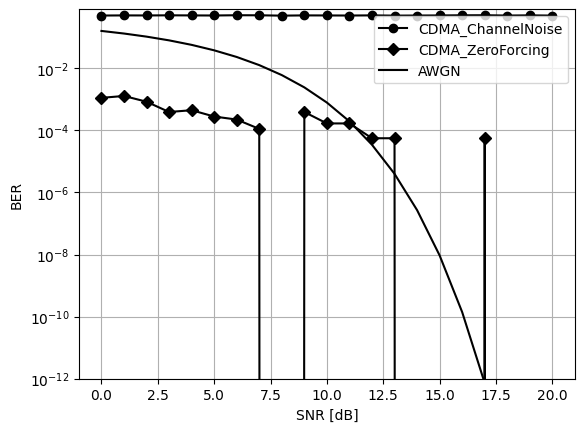

In [32]:
plt.figure()
#plt.semilogy(ebn0, ber_OnlyCode, "V-", label="CDMA_OnlyCode", color="black")
plt.semilogy(ebn0, ber_ChannelNoise, "o-", label="CDMA_ChannelNoise", color="black")
plt.semilogy(ebn0, ber_ZeroForcing, "D-", label="CDMA_ZeroForcing", color="black")
ber_awgn = (1/2)*erfc(np.sqrt(10**(0.1*ebn0)/2))
plt.plot(ebn0, ber_awgn, label="AWGN", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.ylim([10**(-12), 0.8])
plt.savefig("MyBERSNR.png")
plt.show()

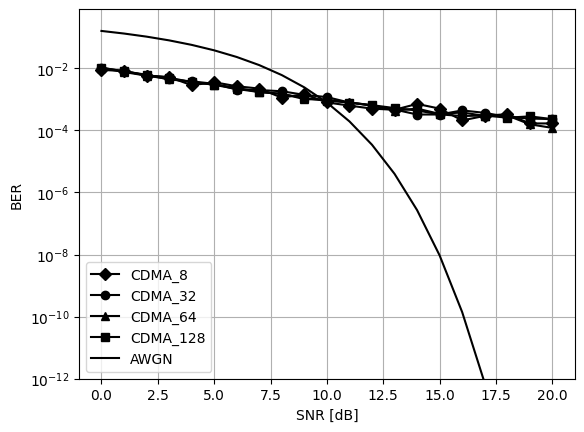

In [ ]:
message = [8, 32, 64, 128]

binary_source = sionna.utils.BinarySource()
channel = sionna.channel.AWGN()rr

ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber_OnlyCode = np.zeros(len(ebn0))
ber_ChannelNoise = np.zeros(len(ebn0))
ber_ZeroForcing = np.zeros(len(ebn0))
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

plt.figure()
symbols = ["D-", "o-", "^-", "s-"]
number=0

for mes in range(len(message)):

    tx_params["nMessage"] = message[mes]

    for i in range(len(ebn0)):

        ber_OnlyCode_i = np.zeros(nb_seq)
        ber_ChannelNoise_i = np.zeros(nb_seq)
        ber_ZeroForcing_i = np.zeros(nb_seq)
        var_noise = 1/(10**(0.1*ebn0[i]))

        #print("message "+str(message[mes])+" ebn0 "+str(i))

        for j in range(nb_seq):

            BinarySource = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()

            data = BinarySource
            data_channel = utils.CDMA_encode(data, tx_params)

            signalOtherCells = np.zeros(data_channel.shape[0])
            for k in range(data_channel.shape[0]):
                signalOtherCells[k] = random.randint(0, 1)
            signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

            h = utils.Rayleigh_canal(alpha, len(data_channel))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape))
            channel = data_channel*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
            zero_forcing = channel/h

            decoded_OnlyCode = utils.CDMA_decode(data_channel, tx_params)
            decoded_ChannelNoise = utils.CDMA_decode(channel, tx_params)
            decoded_ZeroForcing = utils.CDMA_decode(zero_forcing, tx_params)

            decoded_tf_OnlyCode = tf.convert_to_tensor(decoded_OnlyCode)
            decoded_tf_ChannelNoise = tf.convert_to_tensor(decoded_ChannelNoise)
            decoded_tf_ZeroForcing = tf.convert_to_tensor(decoded_ZeroForcing)

            BinarySource = tf.cast(tf.less(0.0, BinarySource), tf.float32)
            decoded_tf_OnlyCode = tf.cast(tf.less(0.0, decoded_tf_OnlyCode), tf.float32)
            decoded_tf_ChannelNoise = tf.cast(tf.less(0.0, decoded_tf_ChannelNoise), tf.float32)
            decoded_tf_ZeroForcing = tf.cast(tf.less(0.0, decoded_tf_ZeroForcing), tf.float32)

            ber_OnlyCode_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_OnlyCode)
            ber_ChannelNoise_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_ChannelNoise)
            ber_ZeroForcing_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf_ZeroForcing)

            ber_OnlyCode_i[j] = ber_OnlyCode_j.numpy()
            ber_ChannelNoise_i[j] = ber_ChannelNoise_j.numpy()
            ber_ZeroForcing_i[j] = ber_ZeroForcing_j.numpy()
            
        ber_OnlyCode[i] = np.mean(ber_OnlyCode_i)
        ber_ChannelNoise[i] = np.mean(ber_ChannelNoise_i)
        ber_ZeroForcing[i] = np.mean(ber_ZeroForcing_i)

    # plt.semilogy(snr_db, ber_OnlyCode, "V-", label="CDMA_OnlyCode", color="black")
    #plt.semilogy(ebn0, ber_ChannelNoise, "o-", label="CDMA_ChannelNoise", color="black")
    plt.semilogy(ebn0, ber_ZeroForcing, symbols[number], label="CDMA_"+str(message[mes]), color="black")
    number+=1
ber_awgn = (1/2)*erfc(np.sqrt(10**(0.1*ebn0)/2))
plt.plot(ebn0, ber_awgn, label="AWGN", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.ylim([10**(-12), 0.8])
plt.savefig("MyBERSNRmessage.png")
plt.show()

tx_params["nMessage"] = 6

spectral efficiency

C:\Users\Dell\AppData\Local\Temp\ipykernel_11024\736664346.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  spectral_efficiency_cdma_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(n[j]+i_interference_cdma[j]))


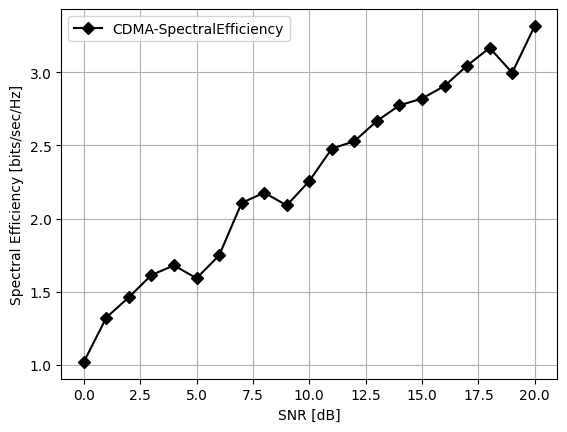

In [ ]:
# spectral efficiency bits/sec/Hz

binary_source = sionna.utils.BinarySource()
channel = sionna.channel.AWGN()

nb_seq = tx_params["nMessage"]*tx_params["nCodeCDMA"]
ebn0 = np.arange(0, 21, 1)
alpha = 0
spectral_efficiency_awgn = np.zeros(len(ebn0))
spectral_efficiency_cdma = np.zeros(len(ebn0))
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])
p_power = 1

for i in range(len(ebn0)):

    spectral_efficiency_awgn_i = np.zeros(nb_seq)
    spectral_efficiency_cdma_i = np.zeros(nb_seq)
    var_noise = 1/(10**(0.1*ebn0[i]))

    for j in range(nb_seq):

        BinarySource = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()

        data = BinarySource
        data_channel = utils.CDMA_encode(data, tx_params) # sent

        signalOtherCells = np.zeros(data_channel.shape[0])
        for k in range(data_channel.shape[0]):
            signalOtherCells[k] = random.randint(0, 1)
        signalOtherCells = utils.Binary2PlusMinusOne(signalOtherCells, int)

        h = utils.Rayleigh_canal(alpha, len(data_channel)) # path
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=data_channel.shape))
        channel = data_channel*h + n + signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"] # received
        zero_forcing = channel/h

        i_interference_cdma = signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        
        spectral_efficiency_cdma_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(n[j]+i_interference_cdma[j]))

    spectral_efficiency_cdma[i] = np.mean(spectral_efficiency_cdma_i)

plt.figure()
plt.plot(ebn0, spectral_efficiency_cdma, "D-", label="CDMA-SpectralEfficiency", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("Spectral Efficiency [bits/sec/Hz]")
plt.xscale("linear")
# plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.savefig("Myspectralefficiency.png")
plt.show()
